
## Parte 1: Sistema de Recomendación


### Librerías


In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from collections import Counter


### Carga de los datos


In [5]:
hotels = pd.read_csv("DataBases/hotels_info_eu.csv")
ratings = pd.read_csv("DataBases/reviews_eu_with_user_id.csv")


In [10]:
hotels = hotels.drop(columns=['Unnamed: 0'])
hotels.head()

,hotel_id,hotel_country,Hotel_Name,Hotel_Address
0,0,Netherlands,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...
1,1,United Kingdom,K K Hotel George,1 15 Templeton Place Earl s Court Kensington a...
2,2,United Kingdom,Apex Temple Court Hotel,1 2 Serjeant s Inn Fleet Street City of London...
3,3,United Kingdom,The Park Grand London Paddington,1 3 Queens Garden Westminster Borough London W...
4,4,France,Monhotel Lounge SPA,1 3 Rue d Argentine 16th arr 75116 Paris France


In [9]:
# Remove columns from the DataFrame
ratings = ratings.drop(columns=['Unnamed: 0', 'temp_id'])
ratings.head()

,user_id,hotel_id,Hotel_Name,Hotel_Address,Reviewer_Nationality,Negative_Review,Positive_Review,Reviewer_Score,Review_Date,given_reviews
0,1,831,H10 Itaca,Avenida Roma 22 30 Eixample 08015 Barcelona Spain,United Arab Emirates,No variety in the breakfast buffet as we can ...,The staff ate very friendly and the location ...,5.4,9/8/2015,3
1,2,913,Jaz Amsterdam,De Passage 90 Noord Holland Zuidoost 1101 AX A...,United Arab Emirates,nothing,bedroom decoration and facilities were great,9.6,6/1/2016,4
2,3,1384,Hotel Manin,Via Manin 7 Milan City Center 20121 Milan Italy,South Africa,At reception not all the staff were courteous,Location,7.1,10/14/2015,1
3,4,77,11 Cadogan Gardens,11 Cadogan Gardens Sloane Square Kensington an...,United States of America,No Negative,Small boutique hotel with friendly staff in a...,10.0,12/21/2016,4
4,5,15,Crowne Plaza London Kings Cross,1 Kings Cross Road Islington London WC1X 9HX U...,United Kingdom,Extra charge to use swimming pool,Lovely room good breakfast,7.9,3/27/2016,1


### Exploración y Anlálisis de los datos

In [17]:
n_ratings = len(ratings)
n_hoteles = ratings['hotel_id'].nunique()
n_usuarios = ratings['user_id'].nunique()

print(f"Total de ratings: {n_ratings}")
print(f"Total de id's unicos de hoteles: {n_hoteles}")
print(f"Total de usuarios unicos: {n_usuarios}")
print(f"Promedio de ratings por usuario: {round(n_ratings/n_usuarios, 2)}")
print(f"Promedio de ratings por hotel: {round(n_ratings/n_hoteles, 2)}")

Total de ratings: 515738
Total de id's unicos de hoteles: 1494
Total de usuarios unicos: 225255
Promedio de ratings por usuario: 2.29
Promedio de ratings por hotel: 345.21


In [66]:
user_freq = ratings[['user_id', 'hotel_id']].groupby('user_id').count().reset_index()
user_freq.columns = ['user_id', 'n_ratings']
print(f"El máximo número de reseñans es {user_freq.n_ratings.max()}, dados por el usuario {user_freq[user_freq.n_ratings == user_freq.n_ratings.max()]['user_id']}")
user_freq.head()

El máximo número de reseñans es 62, dados por el usuario 2392    2393
Name: user_id, dtype: int64


,user_id,n_ratings
0,1,3
1,2,4
2,3,1
3,4,4
4,5,1


In [67]:
user_freq[user_freq.n_ratings == user_freq.n_ratings.max()].user_id

2392    2393
Name: user_id, dtype: int64

In [42]:
print(f"Número de ratings por usuario: {user_freq['n_ratings'].mean():.2f}.")
print(f"Máximo número de ratings dadios por un usuario: {ratings['given_reviews'].max()}")

Número de ratings por usuario: 2.29.
Máximo número de ratings dadios por un usuario: 355


In [63]:
df_user = ratings[ratings.user_id == 2393]
df_user

,user_id,hotel_id,Hotel_Name,Hotel_Address,Reviewer_Nationality,Negative_Review,Positive_Review,Reviewer_Score,Review_Date,given_reviews
4027,2393,847,Megaro Hotel,Belgrove Street Camden London WC1H 8AB United ...,United Kingdom,No complaints,Very convient for Kings X St Pancras Room was...,9.2,9/13/2015,62
8623,2393,849,AC Hotel Victoria Suites a Marriott Lifestyle ...,Beltran i R zpide 7 9 Les Corts 08034 Barcelon...,United Kingdom,The restaurant within the hotel was terrible ...,Close to Nou camp Very clean large Appartment...,8.3,3/6/2017,62
10026,2393,134,Sofitel Paris Arc De Triomphe,14 Rue Beaujon 8th arr 75008 Paris France,United Kingdom,150 supplement per night for fold down bed fo...,Location Luxurious Clean,8.3,4/5/2016,62
16598,2393,324,Hilton London Metropole,225 Edgware Road Westminster Borough London W2...,United Kingdom,Chicken sausages at breakfast were tough Love...,Very nice room and super comfortable bed I ha...,8.8,1/6/2017,62
29176,2393,1022,Fleming s Selection Hotel Wien City,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,United Kingdom,Not 5 star at all no better than a good 3 or ...,Not much,4.6,5/17/2017,62
...,...,...,...,...,...,...,...,...,...,...
431163,2393,148,Hilton London Paddington,146 Praed Street Westminster Borough London W2...,United Kingdom,No free wifi in the rooms cost 15 only free w...,Location right in Paddington station for trav...,9.2,4/8/2017,62
442537,2393,74,Holiday Inn Paris Gare de Lyon Bastille,11 15 Rue De Lyon 12th arr 75012 Paris France,United Kingdom,No Negative,Very convenient for Gare de Lyon station,9.6,8/24/2015,62
446516,2393,186,Britannia International Hotel Canary Wharf,163 Marsh Wall Docklands Tower Hamlets London ...,United Kingdom,The bed was very small and very uncomfortable...,Nice and central to Canary Wharf,7.1,10/15/2015,62
447936,2393,723,The Grand at Trafalgar Square,8 Northumberland Avenue Westminster Borough Lo...,United Kingdom,Nothing,Location,9.2,5/23/2017,62


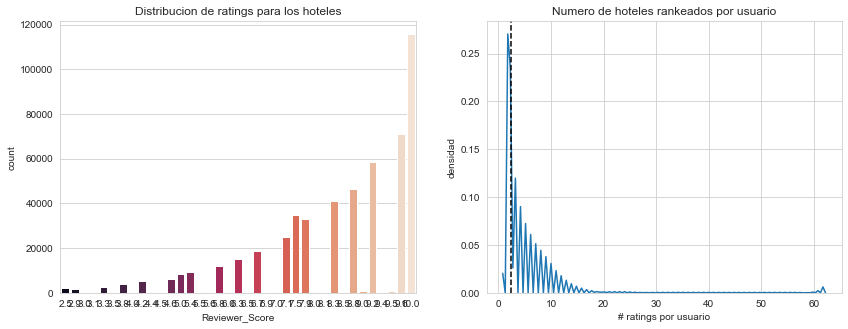

In [39]:
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x='Reviewer_Score',  data=ratings, palette="rocket")
#ax.set_xticks(np.arange(0, 10, step=2))
plt.title("Distribucion de ratings para los hoteles")

plt.subplot(1,2,2)
#ax = sns.kdeplot(user_freq['n_ratings'], fill=True, legend=False)
ax = sns.kdeplot(user_freq['n_ratings'], legend=False)
plt.axvline(user_freq['n_ratings'].mean(), color="k", linestyle="--")
plt.xlabel("# ratings por usuario")
plt.ylabel("densidad")
plt.title("Numero de hoteles rankeados por usuario")
plt.show()

La mayor cantidad de reseñas son positivas


In [82]:
rating_media = ratings.groupby('hotel_id')[['Reviewer_Score']].mean()
rating_bajo = rating_media['Reviewer_Score'].idxmin()

print(f"El Hotel con el rating mas bajo: {ratings[ratings.hotel_id == rating_bajo].Reviewer_Score.sum() / len(ratings[ratings.hotel_id == rating_bajo])}")

hotels.loc[hotels['hotel_id'] == rating_bajo]


El Hotel con el rating mas bajo: 5.121538461538461


,hotel_id,hotel_country,Hotel_Name,Hotel_Address
1444,1444,Italy,Hotel Liberty,Viale Bligny 56 Milan City Center 20136 Milan ...


In [83]:
rating_alto = rating_media['Reviewer_Score'].idxmax()

print(f"El Hotel con el rating mas alto: {ratings[ratings.hotel_id == rating_alto].Reviewer_Score.sum() / len(ratings[ratings.hotel_id == rating_alto])}")
hotels.loc[hotels['hotel_id'] == rating_alto]

El Hotel con el rating mas alto: 9.725


,hotel_id,hotel_country,Hotel_Name,Hotel_Address
156,156,France,Ritz Paris,15 Place Vend me 1st arr 75001 Paris France


In [86]:
print(f"Reseñas altas: {len(ratings[ratings['hotel_id']==rating_alto])}")
print(f"Reseñas bajas: {len(ratings[ratings['hotel_id']==rating_bajo])}")

Reseñas altas: 28
Reseñas bajas: 65


#### Promedio Bayesiano

In [120]:
hotel_stats = ratings.groupby('hotel_id')[['Reviewer_Score']].agg(['count', 'mean'])
hotel_stats.columns = hotel_stats.columns.droplevel()

In [121]:
C = hotel_stats['count'].mean()
m = hotel_stats['mean'].mean()

def promedio_bayesiano(ratings):
    promedio_bayesiano = (C*m+ratings.sum())/(C+ratings.count())
    return promedio_bayesiano

ratings_promedio_bayesiano = ratings.groupby('hotel_id')['Reviewer_Score'].agg(promedio_bayesiano).reset_index()
ratings_promedio_bayesiano.columns = ['hotel_id', 'promedio_bayesiano']
hotel_stats = hotel_stats.merge(ratings_promedio_bayesiano, on='hotel_id')

In [94]:
hotel_stats = hotel_stats.merge(hotels[['hotel_id', 'Hotel_Name', 'hotel_country']])
hotel_stats.sort_values('promedio_bayesiano', ascending=False).head()

,hotel_id,count,mean,promedio_bayesiano,Hotel_Name,hotel_country
25,25,2551,9.451196,9.334018,Intercontinental London The O2,United Kingdom
429,429,1113,9.368553,9.155387,Shangri La Hotel at The Shard London,United Kingdom
1290,1290,1837,9.266413,9.140127,Hotel Esther a,Netherlands
1399,1399,1052,9.339829,9.124453,Hotel Berna,Italy
1315,1315,785,9.391720,9.109614,Amba Hotel Charing Cross,United Kingdom


In [109]:
hotel_stats.sort_values('promedio_bayesiano', ascending=True).head()

,hotel_id,count,mean,promedio_bayesiano,Hotel_Name,hotel_country
186,186,4789,6.826644,6.937010,Britannia International Hotel Canary Wharf,United Kingdom
707,707,920,6.442065,6.994861,Hotel Cavendish,United Kingdom
593,593,953,6.554355,7.063240,Commodore Hotel,United Kingdom
374,374,1273,6.736685,7.106042,Bloomsbury Palace Hotel,United Kingdom
329,329,1107,6.785095,7.185166,Henry VIII,United Kingdom


In [117]:
hotel_statsX = hotel_stats.sort_values('promedio_bayesiano', ascending=False).head().copy()
hotel_statsX.insert(0, 'pos', range(1, len(hotel_statsX)+1))
#hotel_stats.loc[hotel_stats.hotel_id == 186]
len(hotel_statsX)

5

#### Filtrado Colaborativo

para generar recomendaciones. Los datos deben ser homogéneos, implicando que usuarios similares les interesan las mismas cosas. 

Primer paso: transformar los datos en una matriz usuario-item (user-item matrix), donde las filas representan a los usuarios y las columnas represntan a los items para comparar. NO se requiere información sobre los usuarios o los items para generar las recomendaciones

In [124]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Genera una matriz dispersa a partir del dataframe de ratings

    Argumentos:
        df: dataframe en pandas

    Regresa:
        X: matriz dispersa
        mapeo_usuario: dict que mapea el id del usuario con los indices del usuario
        mapeo_inverso_usuario: dict que mapea los indices del usuario con los id's del usuario
        mapeo_hotel: dict que mapea los id's de las peliculas con los indices de las peliculas
        mapeo_inverso_hotel: dict que mapea los indices de las peliculas con los id's de las peliculas
    """
    N = df['user_id'].nunique()
    M = df['hotel_id'].nunique()

    mapeo_usuario = dict(zip(np.unique(df["user_id"]), list(range(N))))
    mapeo_hotel = dict(zip(np.unique(df["hotel_id"]), list(range(M))))

    mapeo_inverso_usuario = dict(zip(list(range(N)), np.unique(df["user_id"])))
    mapeo_inverso_hotel = dict(zip(list(range(M)), np.unique(df["hotel_id"])))

    user_index = [mapeo_usuario[i] for i in df['user_id']]
    hotel_index = [mapeo_hotel[i] for i in df['hotel_id']]

    X = csr_matrix((df["Reviewer_Score"], (hotel_index, user_index)), shape=(M, N))

    return X, mapeo_usuario, mapeo_hotel, mapeo_inverso_usuario, mapeo_inverso_hotel

In [128]:
X, user_mapper, hotel_mapper, user_inv_mapper, hotel_inv_mapper = create_X(ratings)

In [129]:
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])

print(f"Dispersion de la Matriz: {round(sparsity*100,2)}%")

Dispersion de la Matriz: 0.15%


la dispesión no debe ser menor a 0.5% para obtener resultados aceptables. En este caso se tiene una dispersión del 0.15%, indicando que sólo esta cantidad de las celdas de la matriz usuario-item tienen ratings.

In [127]:
from scipy.sparse import save_npz
# guardar la matriz
save_npz('DataBases/matriz_usuario_item_eu.npz', X)

### KNN (K-Nearest Neighbours)

kNN hace uso de metricas de distancias tales como:

1. Similaridad Coseno (Cosine similarity)
2. Distancia Euclidiana (Euclidean distance)
3. Distancia Manhattan (Manhattan distance)
4. Correlacion de Pearson (Pearson correlation )


In [130]:
from sklearn.neighbors import NearestNeighbors

def encuentra_hoteles_parecidos(hotel_id, X, k, metric='cosine', show_distance=False):
    """
    Encuentra los k-vecinos para un hotel dado (a partir de su id)

    Argumentos:
        hotel_id: id del hotel en cuestion
        X: matriz de utilidad usuario-item
        k: numero de hoteles similares a encontrar
        metric: metrica a utilizar para los calculos de kNN

    Devuelve:
        lista de k ID's de hoteles similares
    """
    neighbour_ids = []

    hotel_ind = hotel_mapper[hotel_id]
    hotel_vec = X[hotel_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    if isinstance(hotel_vec, (np.ndarray)):
        hotel_vec = hotel_vec.reshape(1,-1)
    neighbour = kNN.kneighbors(hotel_vec, return_distance=show_distance)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(hotel_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

4789 reseñas provenientes de 93 países en el sub cojunto.


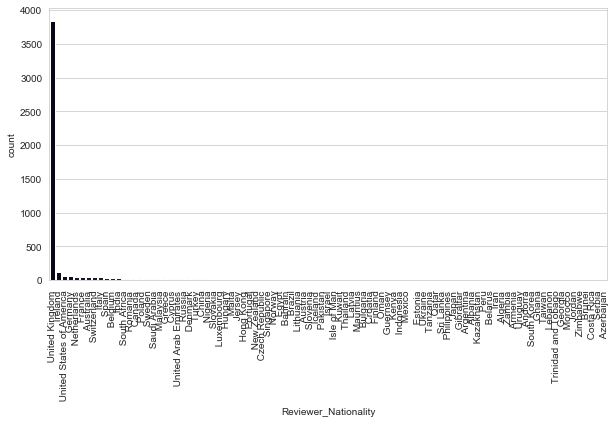

In [224]:
# hotel 186 (peor rankeado)
# -------------------------

ratings_subset = ratings[ratings['hotel_id'] == 186]

contador_paises = Counter(pais for pais in ratings_subset['Reviewer_Nationality'])
print(f"{len(ratings_subset)} reseñas provenientes de {len(contador_paises)} países en el sub cojunto.")

nac_counts_df = pd.DataFrame([contador_paises]).T.reset_index()

nac_counts_df.columns = ['Reviewer_Nationality', 'count']
nac_counts_df = nac_counts_df.sort_values(by='count', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Reviewer_Nationality', y='count', data=nac_counts_df, palette='rocket')
plt.xticks(rotation=90)
plt.show()

Utilizando la métrica del Coseno (por defecto)

In [226]:
nombre_hoteles = dict(zip(hotels['hotel_id'], hotels['Hotel_Name']))

hotel_id = 1290 # tercer mejor rankeado

ids_parecidos = encuentra_hoteles_parecidos(hotel_id, X, k=5)
hotel_nombre = nombre_hoteles[hotel_id]
hotel_pais = hotels.loc[hotels['Hotel_Name'] == hotel_nombre].hotel_country.values[0]

print(f"Porque the hospedaste en el Hotel '{hotel_nombre}' en {hotel_pais},")
print(f"Te pueden interesar los siguientes Hoteles:")
for i in ids_parecidos:
    print(f"\t* ({i}) {nombre_hoteles[i]} en {hotels.loc[hotels['Hotel_Name'] == nombre_hoteles[i]].hotel_country.values[0]}")
    print(f"\t        [reseña promedio: {round(ratings[ratings['hotel_id'] == i]['Reviewer_Score'].mean(), 2)}]")

Porque the hospedaste en el Hotel 'Hotel Esther a' en Netherlands,
Te pueden interesar los siguientes Hoteles:
	* (1480) Park Plaza Westminster Bridge London en United Kingdom
	        [reseña promedio: 8.65]
	* (337) Park Plaza Victoria London en United Kingdom
	        [reseña promedio: 8.55]
	* (1009) Room Mate Aitana en Netherlands
	        [reseña promedio: 8.9]
	* (127) The Chamberlain en United Kingdom
	        [reseña promedio: 9.04]
	* (524) citizenM Tower of London en United Kingdom
	        [reseña promedio: 9.14]


Utilizando la métrica Euclideana:

In [227]:
nombre_hoteles = dict(zip(hotels['hotel_id'], hotels['Hotel_Name']))

hotel_id = 1290 # tercer mejor rankeado

ids_parecidos = encuentra_hoteles_parecidos(hotel_id, X, k=5, metric="euclidean")
hotel_nombre = nombre_hoteles[hotel_id]
hotel_pais = hotels.loc[hotels['Hotel_Name'] == hotel_nombre].hotel_country.values[0]

print(f"Porque the hospedaste en el Hotel '{hotel_nombre}' en {hotel_pais},")
print(f"Te pueden interesar los siguientes Hoteles:")
for i in ids_parecidos:
    print(f"\t* ({i}) {nombre_hoteles[i]} en {hotels.loc[hotels['Hotel_Name'] == nombre_hoteles[i]].hotel_country.values[0]}")
    print(f"\t        [reseña promedio: {round(ratings[ratings['hotel_id'] == i]['Reviewer_Score'].mean(), 2)}]")

Porque the hospedaste en el Hotel 'Hotel Esther a' en Netherlands,
Te pueden interesar los siguientes Hoteles:
	* (1018) Hotel Gallitzinberg en Austria
	        [reseña promedio: 7.88]
	* (1402) Ibis Styles Milano Palmanova en Italy
	        [reseña promedio: 6.38]
	* (5) Kube Hotel Ice Bar en France
	        [reseña promedio: 5.85]
	* (122) Mercure Paris Porte d Orleans en France
	        [reseña promedio: 8.18]
	* (1382) Hotel Wagner en Italy
	        [reseña promedio: 8.43]


Utilizando la métrica de Manhattan

In [228]:
nombre_hoteles = dict(zip(hotels['hotel_id'], hotels['Hotel_Name']))

hotel_id = 1290 # peor rankeado

ids_parecidos = encuentra_hoteles_parecidos(hotel_id, X, k=5, metric="manhattan")
hotel_nombre = nombre_hoteles[hotel_id]
hotel_pais = hotels.loc[hotels['Hotel_Name'] == hotel_nombre].hotel_country.values[0]

print(f"Porque the hospedaste en el Hotel '{hotel_nombre}' en {hotel_pais},")
print(f"Te pueden interesar los siguientes Hoteles:")
for i in ids_parecidos:
    print(f"\t* ({i}) {nombre_hoteles[i]} en {hotels.loc[hotels['Hotel_Name'] == nombre_hoteles[i]].hotel_country.values[0]}")
    print(f"\t        [reseña promedio: {round(ratings[ratings['hotel_id'] == i]['Reviewer_Score'].mean(), 2)}]")

Porque the hospedaste en el Hotel 'Hotel Esther a' en Netherlands,
Te pueden interesar los siguientes Hoteles:
	* (1018) Hotel Gallitzinberg en Austria
	        [reseña promedio: 7.88]
	* (1402) Ibis Styles Milano Palmanova en Italy
	        [reseña promedio: 6.38]
	* (122) Mercure Paris Porte d Orleans en France
	        [reseña promedio: 8.18]
	* (1382) Hotel Wagner en Italy
	        [reseña promedio: 8.43]
	* (946) Hotel Eitlj rg en Austria
	        [reseña promedio: 7.75]


KNN utilizando Nacionalidad de los usuarios


In [210]:
from scipy.sparse import csr_matrix

def create_X_nac(df):
    """
    Genera una matriz dispersa a partir del dataframe de ratings

    Argumentos:
        df: dataframe en pandas

    Regresa:
        X: matriz dispersa
        mapeo_usuario: dict que mapea el id del usuario con los indices del usuario
        mapeo_inverso_usuario: dict que mapea los indices del usuario con los id's del usuario
        mapeo_hotel: dict que mapea los id's de las peliculas con los indices de las peliculas
        mapeo_inverso_hotel: dict que mapea los indices de las peliculas con los id's de las peliculas
    """
    N = df['Reviewer_Nationality'].nunique()
    M = df['hotel_id'].nunique()

    mapeo_usuario = dict(zip(np.unique(df["Reviewer_Nationality"]), list(range(N))))
    mapeo_hotel = dict(zip(np.unique(df["hotel_id"]), list(range(M))))

    mapeo_inverso_usuario = dict(zip(list(range(N)), np.unique(df["Reviewer_Nationality"])))
    mapeo_inverso_hotel = dict(zip(list(range(M)), np.unique(df["hotel_id"])))

    user_index = [mapeo_usuario[i] for i in df['Reviewer_Nationality']]
    hotel_index = [mapeo_hotel[i] for i in df['hotel_id']]

    X = csr_matrix((df["Reviewer_Score"], (hotel_index, user_index)), shape=(M, N))

    return X, mapeo_usuario, mapeo_hotel, mapeo_inverso_usuario, mapeo_inverso_hotel

In [211]:
X_nac, user_mapper, hotel_mapper, user_inv_mapper, hotel_inv_mapper = create_X_nac(ratings)

In [212]:
sparsity = X_nac.count_nonzero()/(X_nac.shape[0]*X_nac.shape[1])

print(f"Dispersion de la Matriz: {round(sparsity*100,2)}%")

Dispersion de la Matriz: 19.22%


In [214]:
nombre_hoteles = dict(zip(hotels['hotel_id'], hotels['Hotel_Name']))

hotel_id = 186 # peor ranqueado

ids_parecidos = encuentra_hoteles_parecidos(hotel_id, X_nac, k=5, metric="euclidean")
hotel_nombre = nombre_hoteles[hotel_id]
hotel_pais = hotels.loc[hotels['Hotel_Name'] == hotel_nombre].hotel_country.values[0]

print(f"Porque the hospedaste en el Hotel '{hotel_nombre}' en {hotel_pais},")
print(f"Te pueden interesar los siguientes Hoteles:")
for i in ids_parecidos:
    print(f"\t* ({i}) {nombre_hoteles[i]} en {hotels.loc[hotels['Hotel_Name'] == nombre_hoteles[i]].hotel_country.values[0]}")
    print(f"\t        [reseña promedio: {round(ratings[ratings['hotel_id'] == i]['Reviewer_Score'].mean(), 2)}]")

Porque the hospedaste en el Hotel 'Britannia International Hotel Canary Wharf' en United Kingdom,
Te pueden interesar los siguientes Hoteles:
	* (486) Strand Palace Hotel en United Kingdom
	        [reseña promedio: 8.13]
	* (689) DoubleTree by Hilton Hotel London Tower of London en United Kingdom
	        [reseña promedio: 8.66]
	* (25) Intercontinental London The O2 en United Kingdom
	        [reseña promedio: 9.45]
	* (1480) Park Plaza Westminster Bridge London en United Kingdom
	        [reseña promedio: 8.65]
	* (1271) Copthorne Tara Hotel London Kensington en United Kingdom
	        [reseña promedio: 8.09]


1837 reseñas provenientes de 76 países en el sub cojunto.


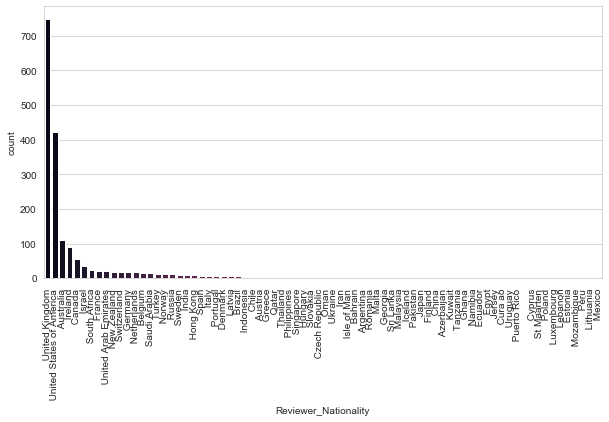

In [225]:
# hotel 1290 (tercer mejor rankeado)
# ----------------------------------

ratings_subset = ratings[ratings['hotel_id'] == 1290]

contador_paises = Counter(pais for pais in ratings_subset['Reviewer_Nationality'])
print(f"{len(ratings_subset)} reseñas provenientes de {len(contador_paises)} países en el sub cojunto.")

nac_counts_df = pd.DataFrame([contador_paises]).T.reset_index()

nac_counts_df.columns = ['Reviewer_Nationality', 'count']
nac_counts_df = nac_counts_df.sort_values(by='count', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Reviewer_Nationality', y='count', data=nac_counts_df, palette='rocket')
plt.xticks(rotation=90)
plt.show()

Euclidean:

In [216]:
nombre_hoteles = dict(zip(hotels['hotel_id'], hotels['Hotel_Name']))

hotel_id = 1290 # tercer mejor rankeado

ids_parecidos = encuentra_hoteles_parecidos(hotel_id, X_nac, k=5, metric="euclidean")
hotel_nombre = nombre_hoteles[hotel_id]
hotel_pais = hotels.loc[hotels['Hotel_Name'] == hotel_nombre].hotel_country.values[0]

print(f"Porque the hospedaste en el Hotel '{hotel_nombre}' en {hotel_pais} [reseña promedio: {round(ratings[ratings['hotel_id'] == hotel_id]['Reviewer_Score'].mean(), 2)}],")
print(f"Te pueden interesar los siguientes Hoteles:")
for i in ids_parecidos:
    print(f"\t* ({i}) {nombre_hoteles[i]} en {hotels.loc[hotels['Hotel_Name'] == nombre_hoteles[i]].hotel_country.values[0]}")
    print(f"\t        [reseña promedio: {round(ratings[ratings['hotel_id'] == i]['Reviewer_Score'].mean(), 2)}]")

Por que the hospedaste en el Hotel 'Hotel Esther a' en Netherlands [reseña promedio: 9.27],
Te pueden interesar los siguientes Hoteles:
	* (363) Park Grand Paddington Court en United Kingdom
	        [reseña promedio: 8.19]
	* (908) Park Plaza Victoria Amsterdam en Netherlands
	        [reseña promedio: 8.13]
	* (1099) Golden Tulip Amsterdam West en Netherlands
	        [reseña promedio: 8.55]
	* (61) The Grosvenor en United Kingdom
	        [reseña promedio: 8.35]
	* (528) St James Court A Taj Hotel London en United Kingdom
	        [reseña promedio: 8.72]


Manhattan:

In [218]:
nombre_hoteles = dict(zip(hotels['hotel_id'], hotels['Hotel_Name']))

hotel_id = 1290 # tercer mejor rankeado

ids_parecidos = encuentra_hoteles_parecidos(hotel_id, X_nac, k=5, metric="manhattan")
hotel_nombre = nombre_hoteles[hotel_id]
hotel_pais = hotels.loc[hotels['Hotel_Name'] == hotel_nombre].hotel_country.values[0]

print(f"Porque the hospedaste en el Hotel '{hotel_nombre}' en {hotel_pais} [reseña promedio: {round(ratings[ratings['hotel_id'] == hotel_id]['Reviewer_Score'].mean(), 2)}],")
print(f"Te pueden interesar los siguientes Hoteles:")
for i in ids_parecidos:
    print(f"\t* ({i}) {nombre_hoteles[i]} en {hotels.loc[hotels['Hotel_Name'] == nombre_hoteles[i]].hotel_country.values[0]}")
    print(f"\t        [reseña promedio: {round(ratings[ratings['hotel_id'] == i]['Reviewer_Score'].mean(), 2)}]")

Porque the hospedaste en el Hotel 'Hotel Esther a' en Netherlands [reseña promedio: 9.27],
Te pueden interesar los siguientes Hoteles:
	* (908) Park Plaza Victoria Amsterdam en Netherlands
	        [reseña promedio: 8.13]
	* (1099) Golden Tulip Amsterdam West en Netherlands
	        [reseña promedio: 8.55]
	* (674) Radisson Blu Edwardian Vanderbilt en United Kingdom
	        [reseña promedio: 8.17]
	* (1304) Ramada Apollo Amsterdam Centre en Netherlands
	        [reseña promedio: 8.3]
	* (61) The Grosvenor en United Kingdom
	        [reseña promedio: 8.35]
